In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

In [3]:
X, y = datasets.make_classification(n_features=8, 
                                    n_classes=3, 
                                    n_informative=5, 
                                    n_samples=1200,
                                    n_clusters_per_class=2)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
class SoftMaxRegression():
    def __init__(self):
        self.classes = None
        self.weights = None
        self.log_loss = []
        self.train_score = []
        
    def fit(self, X, y):
        self.classes = len(np.unique(y))
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        self.weights = np.ones((X.shape[1], self.classes))
        
        for i in range(2000):
            s_k = X.dot(self.weights)
            p_k = self.softmax(s_k)
            
            y_k = np.zeros((X.shape[0], self.classes))
            y_k[np.arange(len(y)), y] = 1
            
            dw = 1 / len(y) * X.T.dot(p_k - y_k)
            self.weights -= dw * 0.1
            
            self.log_loss.append(-np.mean(np.log(p_k[np.arange(len(y)), y])))
            self.train_score.append(self.score(self.predict(X[:, 1:]), y))
    
    def predict(self, X):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        s_k = X.dot(self.weights)
        p_k = self.softmax(s_k)
        return np.argmax(p_k, axis=1)  
    
    def score(self, predicted, y):
        return np.sum(predicted == y) / len(y)
    
    def softmax(self, s_k):
        exp = np.exp(s_k - np.max(s_k))
        for i in range(len(s_k)):
            exp[i] /= np.sum(exp[i])
        return exp

In [7]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def distance(self, x0, x1):
        return np.sqrt(np.sum((x0 - x1)**2))
    
    def most_common(self, y):
        labels = np.unique(y)
        count = [list(y).count(i) for i in labels]
        return labels[np.argmax(count)]
    
    def predict(self, X_test):
        labels = [self.find_labels(x) for x in X_test]
        return np.array(labels)
    
    def find_labels(self, x):
        distances = [self.distance(x, x_train) for x_train in self.X_train]
        k_nearest = np.argsort(distances)[:self.k] 
        labels = [self.y_train[i] for i in k_nearest]
        return self.most_common(labels)
    
    def score(self, predict, y):
        return np.sum(predict == y) / len(y)

In [8]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None

In [9]:
class DecisionTree:
    def __init__(self, min_samples=2, max_depth=10):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.tree = []
    
    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])
    
    def most_common(self, y): 
        labels = np.unique(y)       
        count = [list(y).count(i) for i in labels]        
        return labels[np.argmax(count)]
    
    def entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        entr = -np.sum([p * np.log2(p) for p in ps if p > 0])
        gini = np.sum([p * (1 - p) for p in ps])
        return entr
    
    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_gain = -1
        
        for i in range(X.shape[1]):
            thresholds = np.unique(X[:, i])
            for threshold in thresholds:
                gain = self.information_gain(X[:, i], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def information_gain(self, X_column, y, threshold):        
        if len(np.unique(y)) == 1: 
            return -1
        
        n = len(y)
        parent = self.entropy(y)
        
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()
        
        if len(left_indexes) == 0 or len(right_indexes) == 0:
            return -1
    
        e_l, n_l = self.entropy(y[left_indexes]), len(left_indexes)
        e_r, n_r = self.entropy(y[right_indexes]), len(right_indexes)
        
        child = (n_l / n) * e_l + (n_r / n) * e_r
        return parent - child
    
    def grow_tree(self, X, y, depth=0):
        best_feature, best_threshold = None, None
        n_samples = X.shape[0]
        n_labels = len(np.unique(y))

        if n_samples < self.min_samples or n_labels == 1 or depth >= self.max_depth:
            return Node(value=self.most_common(y))
        
        best_feature, best_threshold = self.best_split(X, y)
        
        if best_feature == None or best_threshold == None:
            return Node(value=self.most_common(y))
        
        left_indexes = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        
        if len(left_indexes) == 0 or len(right_indexes) == 0:
            return Node(value=self.most_common(y))

        left = self.grow_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self.grow_tree(X[right_indexes, :], y[right_indexes], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        if x[tree.feature] <= tree.threshold:
            return self.travers_tree(x, tree.left)

        return self.travers_tree(x, tree.right)
    
    def score(self, predict, y):
        return np.sum(predict == y) / len(y)

In [10]:
models = [SoftMaxRegression(), KNN(k=3), DecisionTree()]
meta = [KNN(k=5)]

In [19]:
class Blending:
    def __init__(self, models):
        self.models = models[:-1]
        self.meta = None
        self.fitted_models = []
        
    def fit(self, X, y):
        n = int(X.shape[0] / 3)
        
        X0, y0 = X[:n, :], y[:n]
        X1, y1 = X[n: n*2, :], y[n: n*2]
        X2, y2 = X[n*2:, :], y[n*2:]
        
        exits, models_score = self.predict_exits(X0, y0, X1, y1)
        self.meta.fit(exits, y1)   
        
        exits, models_score = self.predict_exits(X1, y1, X2, y2, fit_models=False)
        predicted = self.meta.predict(exits)
        
        return self.score(predicted, y2), models_score
        
    def predict_exits(self, X0, y0, X1, y1, fit_models=True):
        exits = None
        models_score = []
        
        for i in range(len(self.models)):
            
            if fit_models:
                clf = self.models[i]
                clf.fit(X0, y0)
                self.fitted_models.append(clf)
                predict = clf.predict(X1)
            else:
                predict = self.fitted_models[i].predict(X1)

            if exits is not None:
                exits = np.hstack((exits, predict[:, np.newaxis]))
            else:
                exits = predict[:, np.newaxis]
                
            models_score.append(self.score(predict, y1))
            
        return exits, models_score
    
    def score(self, predicted, y):
        return np.sum(predicted == y) / len(y)

In [20]:
blend = Blending(models)
blend.fit(X_train, y_train)

(0.7975, [0.6975, 0.82, 0.75])

In [288]:
exits = None
fitted_models = []

X0, X1, y0, y1 = train_test_split(X, y, train_size=0.3)
X1, X2, y1, y2 = train_test_split(X1, y1, train_size=0.5)

for model in models[:-1]:
    clf = model
    clf.fit(X0, y0)
    fitted_models.append(clf)

In [289]:
for fitted_model in fitted_models:    
    predict = fitted_model.predict(X1)
    print("score: ", str(fitted_model.score(predict, y1))[:4], " model: ", str(fitted_model)[10: -30])
    predict = predict[:, np.newaxis]
      
    if exits is not None:
        exits = np.hstack((exits, predict))
    else:
        exits = predict

score:  0.73  model:  SoftMaxRegression
score:  0.78  model:  KNN
score:  0.78  model:  KNN
score:  0.73  model:  DecisionTree
score:  0.73  model:  DecisionTree


In [290]:
labels = [clf.most_common(exits[i]) for i in range(len(y1))]
np.sum(labels == y1) / len(y1)

0.8131868131868132

In [291]:
meta_model = models[-1]
meta_model.fit(exits, y1)

In [292]:
exits = None

for fitted_model in fitted_models:    
    predict = fitted_model.predict(X2)
    print("score: ", str(fitted_model.score(predict, y2))[:5], " model: ", str(fitted_model)[10: -30])
    predict = predict[:, np.newaxis]
      
    if exits is not None:
        exits = np.hstack((exits, predict))
    else:
        exits = predict

score:  0.747  model:  SoftMaxRegression
score:  0.775  model:  KNN
score:  0.784  model:  KNN
score:  0.784  model:  DecisionTree
score:  0.784  model:  DecisionTree


In [293]:
predicted = meta_model.predict(exits)
meta_model.score(predicted, y2)

0.8021978021978022

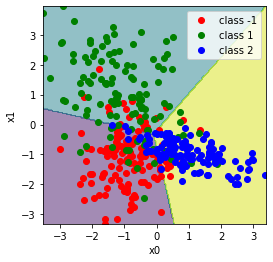

In [11]:
def back_ground(model, X):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    step = 200

    xx, yy = np.meshgrid(np.arange(x_min, x_max + (x_max-x_min) / step, (x_max-x_min) / step),
                         np.arange(y_min, y_max + (y_max-y_min) / step, (y_max-y_min) / step))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)    
    
    return xx, yy, Z

X = X_train
y = y_train

xx, yy, Z = back_ground(clf, X)

fig, axs = plt.subplots(figsize=(4, 4))

plt.plot(X[y==0, 0], X[y==0, 1], "or", label="class -1")
plt.plot(X[y==1, 0], X[y==1, 1], "og", label="class 1")
plt.plot(X[y==2, 0], X[y==2, 1], "ob", label="class 2")
# plt.plot(X[y==3, 0], X[y==3, 1], "ok", label="class 3")

plt.contourf(xx, yy, Z, alpha=0.5)
plt.legend()
plt.xlabel("x0")
plt.ylabel("x1")

plt.show()